In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

Running on cuda


In [2]:
def data_loader(data, batch_size, random_seed=123, valid_size=0.1, shuffle=True,test=False):
    normalise = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([transforms.Resize(224),transforms.CenterCrop(224),transforms.ToTensor(),normalise])
    transform_train = transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.4, hue=0.1),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.RandomGrayscale(p=0.05),
            transforms.GaussianBlur(kernel_size=(5,5), sigma=(0.1, 2.0)),
            transforms.ToTensor(),
            normalise,
            transforms.RandomErasing(p=0.1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),

         ])
    if test:
        dataset = datasets.Flowers102(root=data, split="test", download=True, transform=transform)
        data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)
        print(f"Number of test examples: {len(dataset)}")
        return data_loader
    train_dataset = datasets.Flowers102(root=data, split="train", download=True, transform=transform_train)
    validation_dataset = datasets.Flowers102(root=data, split="val", download=True, transform=transform)
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=shuffle)
    valid_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=True)
    print(f"Number of training examples: {len(train_dataset)}")
    return (train_loader, valid_loader)

train_loader, valid_loader = data_loader(data='flowers', batch_size=4, shuffle=True, test=False)
test_loader = data_loader(data='flowers', batch_size=4, shuffle=True, test=True)


Number of training examples: 1020
Number of test examples: 6149


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


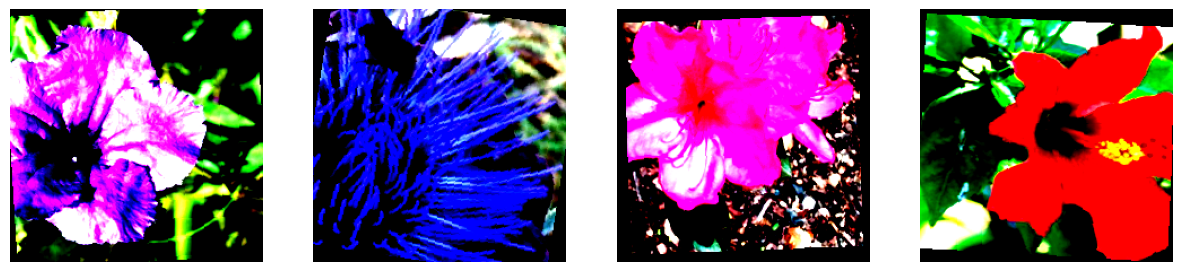

In [3]:
import matplotlib.pyplot as plt
import torchvision
images, labels = next(iter(train_loader))

# Create a grid of images
images, labels = next(iter(train_loader))

# Display images individually
fig, axs = plt.subplots(1, len(images), figsize=(15, 15))

for i, image in enumerate(images):
    axs[i].imshow(image.permute(1, 2, 0))
    axs[i].axis('off')

plt.show()



In [4]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Block, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [5]:
class Rn(nn.Module):
    def __init__(self, block, layers, num_classes=102):
        super(Rn, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels=self.in_planes, out_channels=planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x
    

In [6]:
num_classes = 102
num_epochs = 300
learning_rate = 0.00034912718997841605
weight_decay = 0.0009299070644685586
print_every = 5
save_every = 20
model = Rn(Block, [2,2,2,2], num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
print(train_loader)
total_step = len(train_loader)

In [7]:
def count_parameters(model)->int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

11230758


In [8]:
import requests
def post_discord(epoch,train_loss, val_accuracy):
    data = {
        "username": "Flower Classifier"
    }
    data["embeds"] = [
        {
            "title": "Epoch {} Results".format(epoch),
            "color": 0x00ff00,
            "fields": [
                {
                    "name": "Training Loss",
                    "value": f"{train_loss}",
                    "inline": False
                },
                {
                    "name": "Validation Accuracy",
                    "value": f"{val_accuracy}",
                    "inline": False
                },
            ]
        }
    ]
    r = requests.post("https://discord.com/api/webhooks/1052587856343867392/SnR2U4HIdeF6ShECr0k1Mit6yrl3HgjtCMk_LykGD8eQ1qsZViY8HLeYsoBUXOHYfbgP", json=data)
    print(r.status_code)


In [9]:
import gc
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        gc.collect()
    
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    
    if epoch % print_every == 0 and epoch != 0:
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            correct = 0
            total = 0
            correctT = 0
            totalT = 0
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted==labels).sum().item()
            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                totalT += labels.size(0)
                correctT += (predicted==labels).sum().item()

            print('Training Accuracy accross {} images: {} %'.format(totalT, 100 * correctT / totalT))
            print('Validation Accuracy accross {} images: {} %'.format(total, 100 * correct / total))
            post_discord(epoch+1, '{:.4f}'.format(loss.item()), 100 * correct / total)
            if 100 * correct / total > 70:
                with torch.no_grad():
                    correct = 0
                    total = 0
                    for images, labels in test_loader:
                        images = images.to(device)
                        labels = labels.to(device)
                        outputs = model(images)
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()
                        del images, labels, outputs
                print('Test Accuracy accross {} images: {} %'.format(total, 100 * correct / total))
                if 100 * correct / total > 68:
                    torch.save(model.state_dict(), './models/model-{}TT.pth'.format(100 * correct / total))
    

Epoch [1/1000], Loss: 4.7864
Training Accuracy accross 1020 images: 3.7254901960784315 %
Validation Accuracy accross 1020 images: 4.313725490196078 %
204
Epoch [2/1000], Loss: 3.6383
Epoch [3/1000], Loss: 4.1130
Epoch [4/1000], Loss: 4.0620
Epoch [5/1000], Loss: 4.3719
Epoch [6/1000], Loss: 3.1462
Training Accuracy accross 1020 images: 8.92156862745098 %
Validation Accuracy accross 1020 images: 9.411764705882353 %
204
Epoch [7/1000], Loss: 4.2551
Epoch [8/1000], Loss: 4.2076
Epoch [9/1000], Loss: 4.0260
Epoch [10/1000], Loss: 4.0885
Epoch [11/1000], Loss: 5.0122
Training Accuracy accross 1020 images: 13.137254901960784 %
Validation Accuracy accross 1020 images: 12.352941176470589 %
204
Epoch [12/1000], Loss: 3.8759
Epoch [13/1000], Loss: 3.0446
Epoch [14/1000], Loss: 3.3577
Epoch [15/1000], Loss: 5.0511
Epoch [16/1000], Loss: 4.3624
Training Accuracy accross 1020 images: 17.058823529411764 %
Validation Accuracy accross 1020 images: 18.235294117647058 %
204
Epoch [17/1000], Loss: 4.3568

In [ ]:
torch.save(model.state_dict(), 'model_5.pth')

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))   


In [ ]:
def count_parameters(model)->int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

In [ ]:
print(model)